In [9]:
%matplotlib notebook

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import subprocess
import shutil


In [10]:
field = 'Goodss/'
way  = 'tweak_cosmos_v4/'
name = 'eazy_v1.1_sed'
name_cat = 'goodss_3dhst.v4.1.cat'

# Load all model spectra and main catalog
list =  glob.glob(way + 'eazy*.dat')
main_cat = np.genfromtxt(name_cat, skip_header=2) 
#main_cat = np.genfromtxt(field + name_cat, skip_header=2) 

# Load transmission curves from fortran code by AKI
mar = np.genfromtxt('scor01.txt')
z_tr = mar[:,2]
lam_tr = mar[:,1]
tra_f =  mar[:,0]

In [17]:
# The function of shifting the wavelength and modification amplitude of the flux
def func_1(z, n, x, y):
    l_mod  = (1+z) * x
    mod_flux = n * y
    return l_mod, mod_flux

In [34]:
# A function that takes into account the transmission curves and response function from each filter
def chi2(z, n, lcii, x, y, fil, lam_tr, flux_tr, z_tr, filty, fil_inf, fil_name, toplot=False):
    
    z = float("{0:.2f}".format(z))
    
    # Find the template corresponding to our z and n
    l_obs2, moh = func_1(z, n, x, y)
    lcii = np.array(lcii)


    # Add absorption for object
    con = (z_tr == z)
    lam_tr = lam_tr[con]
    flux_tr = flux_tr[con]
    tra_func = np.interp(l_obs2, lam_tr, flux_tr)
    
    
    # working with type
    l_obs2 = np.array(l_obs2)
    moh = np.array(moh)
    
    sp_ext = np.zeros(len(l_obs2))
    for i in range (len(l_obs2)): 
        sp_ext[i] =  tra_func[i] * moh[i] 
    

    # Sorting
    sp_ext = sp_ext[np.argsort(l_obs2)]
    l_obs2 = l_obs2[np.argsort(l_obs2)]

    
    fit = []    
    # Add response function for all filters
    for i in range(len(fil)):
        num = 0
        spectr = sp_ext.copy()
        
        res, n = get_filter_by_id(fil[i],filty, fil_inf, fil_name)
        
        # Load lambda and flux from response function
        x_res = res[:, 1]
        y_res = res[:, 2]
        
        x_filt = np.array(x_res)
        y_filt = np.array(y_res)
        
        
        lim1 = np.min(x_res)
        lim2 = np.max(x_res)
        
        # Load template lambda
        xx_tem = l_obs2[np.where((l_obs2 >= lim1) & (l_obs2 <= lim2))[0]]
        
        
        filt_int  = np.interp(xx_tem, x_filt, y_filt) 
        
        num = np.trapz(spectr[np.where((l_obs2 >= lim1) & (l_obs2 <= lim2))[0]]*filt_int, xx_tem)  
        
        
        fit.append(num/10**4)
        
        #print("filter", n)
     

    return fit

In [35]:
def hst_flux(id):
    # The column numbers of the flux in the main catalog
    num_fc  = np.array(([18, 30, 39, 48, 75, 78, 81, 84, 57, 66, \
                     72, 21, 24, 36, 42, 15, 12, 87, 89, 91, \
                     93, 95, 97, 99, 101, 103, 105, 107, 109, 111, \
                     113, 54, 63, 9, 60, 69, 27, 45, 51, 33]))


    # The column numbers of the errors in the main catalog
    num_efc = np.array(([19, 31, 40, 49, 76, 79, 82, 85, 58, 67, \
                     73, 22, 25, 37, 43, 16, 13, 88, 90, 92,  \
                     94, 96, 98, 100, 102, 104, 106, 108, 110, 112, \
                     114, 55, 64, 10, 61, 70, 28, 46, 52, 34]))

    # Name of filters
    fil_cat = ['F435', 'F606W', 'F775W', 'F850LP', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'J', 'H', \
               'Ks', 'B', 'V', 'Rc',  'I', 'U', 'U38', 'IA427', 'IA445', 'IA505', 'IA527', 'IA550', \
               'IA574', 'IA598', 'IA624', 'IA651', 'IA679', 'IA738', 'IA767', 'IA797', 'IA856', 'F125W', \
               'F140W', 'F160W', 'tenisJ',  'tenisK', 'F606cand',  'F814Wcand', 'F850LPcand', 'R' ]


    # Central wavelengths of filters
    lambd = np.array(([0.4318, 0.5919, 0.7693, 0.9036, 3.5569, 4.5020, 5.7450, 7.9158, 1.2356, 1.6496, \
                       2.1667, 0.4563, 0.5396, 0.6517, 0.7838, 0.3750, 0.3637, 0.4260, 0.4443, 0.5061, \
                       0.5259, 0.5495, 0.5763, 0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966,\
                       0.8565, 1.2471, 1.3924, 1.5396, 1.2530, 2.1574, 0.5921, 0.8057, 0.9033, 0.6443
                      ]))
    # Spectrum from the catalog HST
    flux_c = []
    erflu_c = []
    filt = []

    for j in range(len(num_fc)):
        for i in range(len(main_cat[0, :])):
            if (i == num_fc[j]) & (main_cat[id - 1, i] > 0):
                flux_c.append(main_cat[id - 1, i])
                erflu_c.append(main_cat[id - 1, int(num_efc[j])])
                filt.append(j)
                
    # Translate the wavelength into angstroms
    lci = lambd[filt] * 10 ** 4

    # Reproduce to a good type
    flux_c = np.array(flux_c)
    erflu_c = np.array(erflu_c)

    # Translate the flow into nano Jansky
    flux_c = [flux_c[i] * 10 ** (2.56) for i in range(len(flux_c))]
    erflu_c = [erflu_c[i] * 10**(2.56) for i in range(len(erflu_c))]

    # Reproduce to a good type again
    flux_c = np.array(flux_c)
    erflu_c = np.array(erflu_c)
    
    
    return lci, flux_c, erflu_c, filt

In [36]:
# The function of shifting the wavelength and modification amplitude of the flux
def func_1(z, n, x, y):
    l_mod  = (1+z) * x
    mod_flux = n * y
    return l_mod, mod_flux

In [37]:
def filt_f():
    #fname = field + 'Eazy/' + 'goodss_3dhst.v4.1.translate'
    fname = 'goodss_3dhst.v4.1.translate'
    filt_list = np.genfromtxt(fname, dtype=None)


    fil = []
    num_fil = []
    for i, j in zip(filt_list[:, 1], np.linspace(0, 87, 88)):
        if j % 2 == 0:
            num_fil.append(np.array(i[1:]).astype(int))
            # print(np.array(i[1:]).astype(int))


    for i, j in zip(filt_list[:, 0], np.linspace(0, 87, 88)):
        if j % 2 == 0:
            fil.append(np.array(i[2:]).astype(str))


    num_fil = np.array(num_fil)
    fil = np.array(fil)

    # Filters and their numbers
    fil = fil[np.argsort(num_fil)]
    num_fil = num_fil[np.argsort(num_fil)]

    # Delete filters that are not in the article
    hi = [19, 20, 29, 33]
    num_fil = np.delete(num_fil, hi)
    fil = np.delete(fil, hi)
    #-------------------------
    
    filters_info = []
    for line in open( 'FILTER.RES.latest.info', 'r'):
        filters_info.append(np.array(line.split()))
    filters_info = np.array(filters_info)
    #--------------------------
    
    temp_filters = open('FILTER.RES.latest', 'r')
    filters = []
    filters_names = []
    first = True

    l = 0
    for line in temp_filters:

        if line[0] == ' ':

            if not first:
                filters.append(np.array(temp))
                l += 1

            first = False
            filters_names.append(line.split())
            temp = []

        else:
            temp.append(np.array(line.split()).astype('float'))
    
    # filters - include response function for each filter
    # filters_name - include all filters name

    filters = np.array(filters)
    filters_names = np.array(filters_names)
    
    return num_fil, filters, filters_info, filters_names
    
    
# It return name and response function for each filter by id in num_fil
def get_filter_by_id(idi,filtt, filters_info, filters_names):
    temp = np.array([a[0] for a in filters_info]).astype(int)
    name = filters_info[np.where(temp == idi)[0][0]][1]
    names = np.array([a[1] for a in filters_names])
    lam =  np.array([a[4] for a in filters_info[np.where(name == names)[0]]])
    ress = filtt[np.where(name == names)[0][0]]
   
    return ress, name

In [72]:
def get_z(id):
    
    
    lci, flux_c, erflu_c, filt = hst_flux(id)
    num_fill, filters, filters_info, filters_names  = filt_f()
    
    # Take for response function only those filters which have flux in data
    num_fill = num_fill[filt]
    
    z_list = np.arange(0.01, 10, 0.05)
    L2 = np.ones((len(z_list)))
    k = 2

    # Template wavelengths and fluxes
    x = np.genfromtxt(list[k])[:, 0]
    y = np.genfromtxt(list[k])[:, 1]
    
    for i in range(len(z_list)):
    
        l1 = []
        n=0
        fitz = chi2(z_list[i], 1, lci, x, y, num_fill, mar[:,1], mar[:,0], mar[:,2],filters,filters_info, filters_names)

        a = np.sum(np.array(fitz)**2 / erflu_c**2)
        b = -2*np.sum(flux_c*np.array(fitz)/ erflu_c**2)    
        c = np.sum(flux_c**2/erflu_c**2)

        n = -b/(2*a)
        for j in range(len(fitz)):
              l1.append( (flux_c[j] - n*np.array(fitz)[j])** 2 / (np.array(erflu_c)[j] ** 2) )
        L2[i] = np.sum(l1) 
        
       
        '''
        if (z_list[i]==3.01) or (z_list[i]==4.01) or (z_list[i]==5.01) or (z_list[i]==6.01) or (z_list[i]==7.01): 
       
            fig = plt.figure(i + 999)
            ax2 = fig.add_subplot(1,1,1)

            #    print(z_list[i])
            ax2.errorbar(lci, flux_c, fmt= 'o', label='Observed fluxes',markersize='5', elinewidth=1,yerr = erflu_c)
            ax2.plot(lci, n*np.array(fitz),  "*", color='magenta', label =  'FIT')
            plt.legend(loc='lower right')
            plt.title("M2, Z = " + str(z_list[i]))
            print("yes")
        '''
        
    redsh = z_list[np.argmax(np.exp(-(np.array(L2/100)-np.min(np.array(L2/100)))))]
    
    return z_list, L2, redsh
    


5.21


<IPython.core.display.Javascript object>


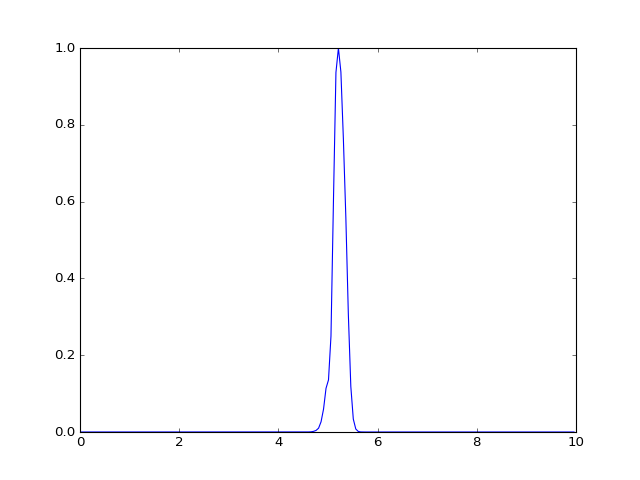

In [74]:
# Redshift and chi2 for any object
zz, chii, red = get_z(5647)
print(red)
plt.close()
plt.plot(zz, np.exp(-(np.array(chii/100)-np.min(np.array(chii/100)))))


# Important part 

In [81]:
def get_z_chi2(id, zd):
    
   
    lci, flux_c, erflu_c, filt = hst_flux(id)
    num_fill, filters, filters_info, filters_names  = filt_f()
    
    # Take for response function only those filters which have flux in data
    num_fill = num_fill[filt]
    
    z_list = np.arange(0.01, 10, 0.05)
    k = 2

    # Template wavelengths and fluxes
    x = np.genfromtxt(list[k])[:, 0]
    y = np.genfromtxt(list[k])[:, 1]
    
    l1 = []
    n=0
    fitz = chi2(zd, 1, lci, x, y, num_fill, mar[:,1], mar[:,0], mar[:,2],filters,filters_info, filters_names)

    a = np.sum(np.array(fitz)**2 / erflu_c**2)
    b = -2*np.sum(flux_c*np.array(fitz)/ erflu_c**2)    
    c = np.sum(flux_c**2/erflu_c**2)

    nn = -b/(2*a)
    for j in range(len(fitz)):
          l1.append( (flux_c[j] - nn*np.array(fitz)[j])** 2 / (np.array(erflu_c)[j] ** 2) )
            
    c2 = np.sum(l1) 

    
    plt.close()
    fig = plt.figure(6666)
    ax = fig.add_subplot(1,1,1)
    ax.errorbar(lci, flux_c, fmt = 'o', label = 'Observed fluxes', markersize = '5', elinewidth = 1, yerr = erflu_c)
    ax.plot(lci, nn*np.array(fitz),  "*", color='magenta', label =  'FIT')
    plt.ylim(0, max(flux_c))
    plt.legend(loc = 'lower right') 
    
    return c2

<IPython.core.display.Javascript object>


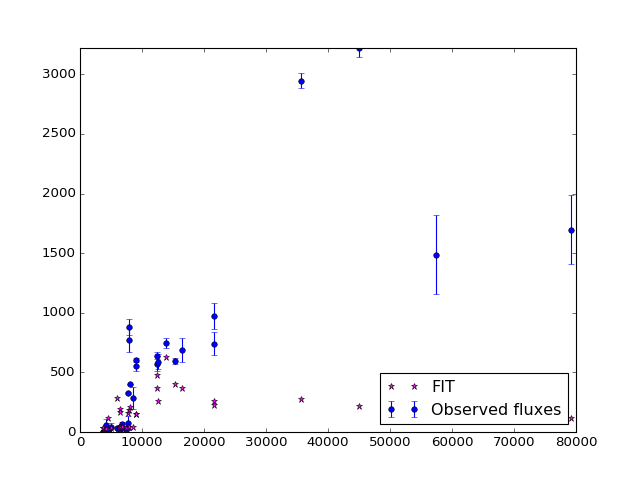

In [82]:
chiii2 = get_z_chi2(5647, 2.01)

In [83]:
print(chiii2)

8062.82202261
